# Artificial intelligence and machine learning project

In [2]:
# required libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from pyampute.exploration.mcar_statistical_tests import MCARTest

from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Import dataset

In [3]:
dat = pd.read_csv("Shared material/alien_galaxy.csv")
print(f'dimensions of alien galaxy data is {dat.shape}')
print(dat.dtypes)
dat.head()

dimensions of alien galaxy data is (2240, 34)
Peace_Treaty_Accords                   float64
Technological_Advancements             float64
Ammonia_Concentration                  float64
Precious_Metal_Trade_Tons              float64
Food_Production_Tons                   float64
Trade_Agreements_Signed                float64
Last_Contact_Days                      float64
Discovery_Date                          object
Mineral_Extraction_Tons                float64
Galactic_Visits                        float64
Sulfur_Concentration                   float64
Exploration_Missions                   float64
Biological_Research_Units              float64
Offspring_Colonies                     float64
Cultural_Exchange_Programs             float64
Military_Engagements                   float64
Inhabitants_Disputes                   float64
Resource_Mining_Operations             float64
Resource_Allocation_Credits            float64
Young_Colonies                         float64
HeavyMetals_Co

Peace_Treaty_Accords  Technological_Advancements  Ammonia_Concentration  \
0                   0.0                         0.0                    1.0   
1                   0.0                         0.0                    2.0   
2                   NaN                         0.0                    1.0   
3                   0.0                         0.0                    1.0   
4                   0.0                         0.0                    0.0   

   Precious_Metal_Trade_Tons  Food_Production_Tons  Trade_Agreements_Signed  \
0                       40.0                 107.0                      1.0   
1                      108.0                  49.0                      1.0   
2                      161.0                  53.0                      NaN   
3                      107.0                   NaN                      3.0   
4                       29.0                  59.0                      7.0   

   Last_Contact_Days Discovery_Date  Mineral_Extraction_Tons  Galactic_Visits  \
0               13.0     26-02-2030                    391.0              3.0   
1                NaN     29-11-2028                      NaN              2.0   
2               61.0     22-03-2029                    363.0              5.0   
3                NaN     15-01-2030                     53.0              7.0   
4               24.0     06-08-2029                    177.0              3.0   

   ...  Alien_Population_Count  CO2_Concentration  \
0  ...                 78285.0               10.0   
1  ...                 62772.0               10.0   
2  ...                 69016.0                5.0   
3  ...                 43795.0                NaN   
4  ...                 57957.0                8.0   

   Dominant_Species_Social_Structure  Hydrogen_Concentration  \
0                            Married                   98.55   
1                             Single                   66.36   
2                            Married                   25.23   
3                           Together                   44.59   
4                           Together                   90.67   

   Colonization_Year  Species_Expansion_Response  Galactic_Trade_Revenue  \
0             3118.0                         NaN                    11.0   
1             3099.0                         0.0                    11.0   
2             3100.0                         0.0                    11.0   
3             3098.0                         1.0                    11.0   
4             3089.0                         0.0                    11.0   

   Alien_Civilization_Level  Interstellar_Contact_Cost  \
0                    Master                        3.0   
1                    Master                        3.0   
2                Graduation                        3.0   
3                    Master                        3.0   
4                Graduation                        3.0   

   Interplanetary_Communications  
0                            6.0  
1                            5.0  
2                            8.0  
3                            7.0  
4                            4.0  

[5 rows x 34 columns]

### 1. Data cleaning
From data head, few variables are observed as unnecessary, so we are dropping these variables. 

In [4]:
# droping unnecessary variables
dat = dat.drop(['Colonization_Year', 'Planet_ID', 'Discovery_Date'], axis=1)

In [5]:
# extracting object type variables to check levels and frequencies
obj_dat = dat.select_dtypes('object')
print(f'Number of object types features are {obj_dat.shape[1]}')
obj_dat.head()

Number of object types features are 2


Dominant_Species_Social_Structure Alien_Civilization_Level
0                           Married                   Master
1                            Single                   Master
2                           Married               Graduation
3                          Together                   Master
4                          Together               Graduation

In [6]:
print(dat.describe(include="object"))
print(f'Frequency of each level of Dominant species social structure is \n {dat[obj_dat.columns[0]].value_counts()}')
print(f'Frequency of each level of Alien civilization level is \n {dat[obj_dat.columns[1]].value_counts()}')
#NOTE: The instances for which Dominant species social structure is ('Absurd', 'YOLO') will be dropped. ('Married', 'Together') will be merged as 'Married' 
# and ('Single', 'Alone') will be merged.
# For instances of  Alien civilization level, where category are Basic will be merged as Graduation and 2n Cycle will be merged with Master. 

       Dominant_Species_Social_Structure Alien_Civilization_Level
count                               2007                     2018
unique                                 8                        5
top                              Married               Graduation
freq                                 771                     1014
Frequency of each level of Dominant species social structure is 
 Dominant_Species_Social_Structure
Married     771
Together    523
Single      427
Divorced    208
Widow        72
Alone         3
YOLO          2
Absurd        1
Name: count, dtype: int64
Frequency of each level of Alien civilization level is 
 Alien_Civilization_Level
Graduation    1014
PhD            431
Master         340
2n Cycle       186
Basic           47
Name: count, dtype: int64


In [7]:
# Merging the relevant categories of Alien_Civilization_Level
dat1 = dat
dat1['Alien_Civilization_Level'] = dat1['Alien_Civilization_Level'].replace({'2n Cycle': 'Master', 
                                                                             'Basic' : 'Graduation'})
dat1['Alien_Civilization_Level'].value_counts()

Alien_Civilization_Level
Graduation    1061
Master         526
PhD            431
Name: count, dtype: int64

In [8]:
# we will remove instances with the two unknown categoies; Absurd and YOLO
dat2 = dat1
ind_dsss = dat2[(dat1['Dominant_Species_Social_Structure'] == 'Absurd') | 
               (dat1['Dominant_Species_Social_Structure'] == 'YOLO')].index
dat2 = dat1.drop(index=ind_dsss)

# merge the relevant categories of Dominant_Species_Social_Structure

dat2['Dominant_Species_Social_Structure'] = dat1['Dominant_Species_Social_Structure'].replace({'Together': 'Married', 
                                                                                               'Alone': 'Single'})
print(f'Dimension of data now is {dat1.shape}')
dat2['Dominant_Species_Social_Structure'].value_counts()

Dimension of data now is (2240, 31)


Dominant_Species_Social_Structure
Married     1294
Single       430
Divorced     208
Widow         72
Name: count, dtype: int64

### 2. Exploratory data analysis

#### Summary statistics

In [9]:
ss = np.transpose(dat2.describe())
ss
#NOTE: count column giving information about variation of mising values in each feature. 
#Most of the features has 0 as minimum, 25%, 50%, and 75% value. 

count          mean           std  \
Peace_Treaty_Accords                 2002.0      0.067433      0.250832   
Technological_Advancements           2025.0      0.065679      0.247781   
Ammonia_Concentration                2020.0      1.478713      1.008160   
Precious_Metal_Trade_Tons            2023.0     44.042511     52.395808   
Food_Production_Tons                 1991.0     26.162230     39.671735   
Trade_Agreements_Signed              2031.0      2.309700      1.890630   
Last_Contact_Days                    2003.0     48.920619     28.998177   
Mineral_Extraction_Tons              2029.0    164.826516    223.506398   
Galactic_Visits                      2017.0      5.331681      2.431105   
Sulfur_Concentration                 2028.0      1.983728      1.413597   
Exploration_Missions                 2015.0      2.660050      2.944887   
Biological_Research_Units            2029.0     37.729423     54.856260   
Offspring_Colonies                   1999.0      0.445223      0.539599   
Cultural_Exchange_Programs           2014.0      0.013406      0.115035   
Military_Engagements                 2018.0      0.072349      0.259129   
Inhabitants_Disputes                 2009.0      0.009457      0.096813   
Resource_Mining_Operations           2006.0      5.755234      3.238547   
Resource_Allocation_Credits          2037.0     26.725577     41.031791   
Young_Colonies                       2011.0      0.505719      0.543933   
HeavyMetals_Concentration            2027.0      2.991613      1.045098   
Terraforming_Initiatives             2007.0      0.074240      0.262227   
Liquid_Energy_Consumption_Terawatts  1990.0    302.888945    336.333624   
Alien_Population_Count               1996.0  52053.992986  25569.491646   
CO2_Concentration                    2045.0      5.444499      2.888752   
Hydrogen_Concentration               2006.0     59.855508     34.538448   
Species_Expansion_Response           2035.0      0.145455      0.352645   
Galactic_Trade_Revenue               1980.0     11.000000      0.000000   
Interstellar_Contact_Cost            2022.0      3.000000      0.000000   
Interplanetary_Communications        2013.0      4.089916      2.709119   

                                         min         25%        50%  \
Peace_Treaty_Accords                    0.00      0.0000      0.000   
Technological_Advancements              0.00      0.0000      0.000   
Ammonia_Concentration                   0.00      1.0000      1.000   
Precious_Metal_Trade_Tons               0.00      8.0000     24.000   
Food_Production_Tons                    0.00      1.0000      8.000   
Trade_Agreements_Signed                 0.00      1.0000      2.000   
Last_Contact_Days                       0.00     24.0000     49.000   
Mineral_Extraction_Tons                 0.00     16.0000     67.000   
Galactic_Visits                         0.00      3.0000      6.000   
Sulfur_Concentration                    0.00      1.0000      2.000   
Exploration_Missions                    0.00      0.0000      2.000   
Biological_Research_Units               0.00      3.0000     12.000   
Offspring_Colonies                      0.00      0.0000      0.000   
Cultural_Exchange_Programs              0.00      0.0000      0.000   
Military_Engagements                    0.00      0.0000      0.000   
Inhabitants_Disputes                    0.00      0.0000      0.000   
Resource_Mining_Operations              0.00      3.0000      5.000   
Resource_Allocation_Credits             0.00      1.0000      8.000   
Young_Colonies                          0.00      0.0000      0.000   
HeavyMetals_Concentration               0.00      2.0000      3.000   
Terraforming_Initiatives                0.00      0.0000      0.000   
Liquid_Energy_Consumption_Terawatts     0.00     23.0000    172.500   
Alien_Population_Count               1730.00  34939.5000  51136.000   
CO2_Concentration                       1.00      3.0000      5.000   
Hydrogen_Con

In [10]:
# create dataframe of only numeric variables to make scatterplot matrix
num_dat = dat.select_dtypes("float64")
print(f'number of numeric features are {num_dat.shape[1]}')
num_dat.head()

number of numeric features are 29


Peace_Treaty_Accords  Technological_Advancements  Ammonia_Concentration  \
0                   0.0                         0.0                    1.0   
1                   0.0                         0.0                    2.0   
2                   NaN                         0.0                    1.0   
3                   0.0                         0.0                    1.0   
4                   0.0                         0.0                    0.0   

   Precious_Metal_Trade_Tons  Food_Production_Tons  Trade_Agreements_Signed  \
0                       40.0                 107.0                      1.0   
1                      108.0                  49.0                      1.0   
2                      161.0                  53.0                      NaN   
3                      107.0                   NaN                      3.0   
4                       29.0                  59.0                      7.0   

   Last_Contact_Days  Mineral_Extraction_Tons  Galactic_Visits  \
0               13.0                    391.0              3.0   
1                NaN                      NaN              2.0   
2               61.0                    363.0              5.0   
3                NaN                     53.0              7.0   
4               24.0                    177.0              3.0   

   Sulfur_Concentration  ...  HeavyMetals_Concentration  \
0                   0.0  ...                        4.0   
1                   3.0  ...                        3.0   
2                   NaN  ...                        2.0   
3                   2.0  ...                        3.0   
4                   2.0  ...                        3.0   

   Terraforming_Initiatives  Liquid_Energy_Consumption_Terawatts  \
0                       0.0                                647.0   
1                       0.0                                581.0   
2                       0.0                                726.0   
3                       0.0                                314.0   
4                       0.0                                290.0   

   Alien_Population_Count  CO2_Concentration  Hydrogen_Concentration  \
0                 78285.0               10.0                   98.55   
1                 62772.0               10.0                   66.36   
2                 69016.0                5.0                   25.23   
3                 43795.0                NaN                   44.59   
4                 57957.0                8.0                   90.67   

   Species_Expansion_Response  Galactic_Trade_Revenue  \
0                         NaN                    11.0   
1                         0.0                    11.0   
2                         0.0                    11.0   
3                         1.0                    11.0   
4                         0.0                    11.0   

   Interstellar_Contact_Cost  Interplanetary_Communications  
0                        3.0                            6.0  
1                        3.0                            5.0  
2                        3.0                            8.0  
3                        3.0                            7.0  
4                        3.0                            4.0  

[5 rows x 29 columns]

In [11]:
# creating scatter plot matric to observe how variables are inter-related.
sns.set_theme(style='ticks')
sns.pairplot(num_dat)
#NOTE: few features such as Peace_Treaty_Accords, Cultural_Exchange_Programs, Cultural_Exchange_Programs, Military_Engagements, Inhabitants_Disputes, 
# Terraforming_Initiatives, Galactic_Trade_Revenue, Interstellar_Contact_Cost are identified to be explored further 
#(aim is to drop these features-- because of being approximately a constant in term of its values).

In [12]:
print(num_dat['Peace_Treaty_Accords'].value_counts())
print(num_dat['Technological_Advancements'].value_counts())
print(num_dat['Cultural_Exchange_Programs'].value_counts())
print(num_dat['Military_Engagements'].value_counts())
print(num_dat['Inhabitants_Disputes'].value_counts())
print(num_dat['Terraforming_Initiatives'].value_counts())
#NOTE: Majority of planets has no peace treaty accords, technological advancements, cultural exchange programs, military engegements, 
# inhabitants dispute, and terraforming initiatives,
print(num_dat['Galactic_Trade_Revenue'].value_counts()) #only one value planets
print(num_dat['Interstellar_Contact_Cost'].value_counts()) #only one value for all planets
#NOTE: drop these variables since these values are almost constant for all planets

Peace_Treaty_Accords
0.0    1870
1.0     135
Name: count, dtype: int64
Technological_Advancements
0.0    1894
1.0     134
Name: count, dtype: int64
Cultural_Exchange_Programs
0.0    1989
1.0      27
Name: count, dtype: int64
Military_Engagements
0.0    1874
1.0     146
Name: count, dtype: int64
Inhabitants_Disputes
0.0    1992
1.0      19
Name: count, dtype: int64
Terraforming_Initiatives
0.0    1860
1.0     150
Name: count, dtype: int64
Galactic_Trade_Revenue
11.0    1983
Name: count, dtype: int64
Interstellar_Contact_Cost
3.0    2025
Name: count, dtype: int64


In [13]:
print(num_dat.columns.tolist())

['Peace_Treaty_Accords', 'Technological_Advancements', 'Ammonia_Concentration', 'Precious_Metal_Trade_Tons', 'Food_Production_Tons', 'Trade_Agreements_Signed', 'Last_Contact_Days', 'Mineral_Extraction_Tons', 'Galactic_Visits', 'Sulfur_Concentration', 'Exploration_Missions', 'Biological_Research_Units', 'Offspring_Colonies', 'Cultural_Exchange_Programs', 'Military_Engagements', 'Inhabitants_Disputes', 'Resource_Mining_Operations', 'Resource_Allocation_Credits', 'Young_Colonies', 'HeavyMetals_Concentration', 'Terraforming_Initiatives', 'Liquid_Energy_Consumption_Terawatts', 'Alien_Population_Count', 'CO2_Concentration', 'Hydrogen_Concentration', 'Species_Expansion_Response', 'Galactic_Trade_Revenue', 'Interstellar_Contact_Cost', 'Interplanetary_Communications']


In [14]:

print(num_dat.columns.tolist())

num_dat = num_dat.drop(['Peace_Treaty_Accords', 'Technological_Advancements', 'Cultural_Exchange_Programs', 
                  'Military_Engagements', 'Inhabitants_Disputes', 'Terraforming_Initiatives', 
                  'Galactic_Trade_Revenue', 'Interstellar_Contact_Cost'], axis=1)
num_dat.head()

['Peace_Treaty_Accords', 'Technological_Advancements', 'Ammonia_Concentration', 'Precious_Metal_Trade_Tons', 'Food_Production_Tons', 'Trade_Agreements_Signed', 'Last_Contact_Days', 'Mineral_Extraction_Tons', 'Galactic_Visits', 'Sulfur_Concentration', 'Exploration_Missions', 'Biological_Research_Units', 'Offspring_Colonies', 'Cultural_Exchange_Programs', 'Military_Engagements', 'Inhabitants_Disputes', 'Resource_Mining_Operations', 'Resource_Allocation_Credits', 'Young_Colonies', 'HeavyMetals_Concentration', 'Terraforming_Initiatives', 'Liquid_Energy_Consumption_Terawatts', 'Alien_Population_Count', 'CO2_Concentration', 'Hydrogen_Concentration', 'Species_Expansion_Response', 'Galactic_Trade_Revenue', 'Interstellar_Contact_Cost', 'Interplanetary_Communications']


Ammonia_Concentration  Precious_Metal_Trade_Tons  Food_Production_Tons  \
0                    1.0                       40.0                 107.0   
1                    2.0                      108.0                  49.0   
2                    1.0                      161.0                  53.0   
3                    1.0                      107.0                   NaN   
4                    0.0                       29.0                  59.0   

   Trade_Agreements_Signed  Last_Contact_Days  Mineral_Extraction_Tons  \
0                      1.0               13.0                    391.0   
1                      1.0                NaN                      NaN   
2                      NaN               61.0                    363.0   
3                      3.0                NaN                     53.0   
4                      7.0               24.0                    177.0   

   Galactic_Visits  Sulfur_Concentration  Exploration_Missions  \
0              3.0                   0.0                   4.0   
1              2.0                   3.0                   6.0   
2              5.0                   NaN                   9.0   
3              7.0                   2.0                   3.0   
4              3.0                   2.0                   6.0   

   Biological_Research_Units  ...  Resource_Mining_Operations  \
0                      175.0  ...                         NaN   
1                       43.0  ...                        11.0   
2                      123.0  ...                        13.0   
3                        4.0  ...                         4.0   
4                       77.0  ...                         8.0   

   Resource_Allocation_Credits  Young_Colonies  HeavyMetals_Concentration  \
0                         67.0             0.0                        4.0   
1                          8.0             1.0                        3.0   
2                        107.0             1.0                        2.0   
3                          3.0             1.0                        3.0   
4                          5.0             1.0                        3.0   

   Liquid_Energy_Consumption_Terawatts  Alien_Population_Count  \
0                                647.0                 78285.0   
1                                581.0                 62772.0   
2                                726.0                 69016.0   
3                                314.0                 43795.0   
4                                290.0                 57957.0   

   CO2_Concentration  Hydrogen_Concentration  Species_Expansion_Response  \
0               10.0                   98.55                         NaN   
1               10.0                   66.36                         0.0   
2                5.0                   25.23                         0.0   
3                NaN                   44.59                         1.0   
4                8.0                   90.67                         0.0   

   Interplanetary_Communications  
0                            6.0  
1                            5.0  
2                            8.0  
3                            7.0  
4                            4.0  

[5 rows x 21 columns]

#### Missing values plot

In [15]:
# number and percentage of missing values according to columns
{col: [dat2[col].isnull().sum(), f'% {np.round(np.mean(dat2[col].isnull()*100), 2)}'] 
 for col in dat2.columns if dat2[col].isnull().any()}

{'Peace_Treaty_Accords': [np.int64(235), '% 10.51'],
 'Technological_Advancements': [np.int64(212), '% 9.48'],
 'Ammonia_Concentration': [np.int64(217), '% 9.7'],
 'Precious_Metal_Trade_Tons': [np.int64(214), '% 9.57'],
 'Food_Production_Tons': [np.int64(246), '% 11.0'],
 'Trade_Agreements_Signed': [np.int64(206), '% 9.21'],
 'Last_Contact_Days': [np.int64(234), '% 10.46'],
 'Mineral_Extraction_Tons': [np.int64(208), '% 9.3'],
 'Galactic_Visits': [np.int64(220), '% 9.83'],
 'Sulfur_Concentration': [np.int64(209), '% 9.34'],
 'Exploration_Missions': [np.int64(222), '% 9.92'],
 'Biological_Research_Units': [np.int64(208), '% 9.3'],
 'Offspring_Colonies': [np.int64(238), '% 10.64'],
 'Cultural_Exchange_Programs': [np.int64(223), '% 9.97'],
 'Military_Engagements': [np.int64(219), '% 9.79'],
 'Inhabitants_Disputes': [np.int64(228), '% 10.19'],
 'Resource_Mining_Operations': [np.int64(231), '% 10.33'],
 'Resource_Allocation_Credits': [np.int64(200), '% 8.94'],
 'Young_Colonies': [np.int64(2

In [16]:
dum1 = pd.get_dummies(dat2['Alien_Civilization_Level'], prefix='AlienCivilizationLevel' ,dtype= 'float64')
dum2 = pd.get_dummies(dat2['Dominant_Species_Social_Structure'], prefix='DominantSpeciesSocialStructure' ,dtype= 'float64')
dat3 = num_dat#pd.concat([num_dat, dum1, dum2], axis=1)
dat3.head()

Ammonia_Concentration  Precious_Metal_Trade_Tons  Food_Production_Tons  \
0                    1.0                       40.0                 107.0   
1                    2.0                      108.0                  49.0   
2                    1.0                      161.0                  53.0   
3                    1.0                      107.0                   NaN   
4                    0.0                       29.0                  59.0   

   Trade_Agreements_Signed  Last_Contact_Days  Mineral_Extraction_Tons  \
0                      1.0               13.0                    391.0   
1                      1.0                NaN                      NaN   
2                      NaN               61.0                    363.0   
3                      3.0                NaN                     53.0   
4                      7.0               24.0                    177.0   

   Galactic_Visits  Sulfur_Concentration  Exploration_Missions  \
0              3.0                   0.0                   4.0   
1              2.0                   3.0                   6.0   
2              5.0                   NaN                   9.0   
3              7.0                   2.0                   3.0   
4              3.0                   2.0                   6.0   

   Biological_Research_Units  ...  Resource_Mining_Operations  \
0                      175.0  ...                         NaN   
1                       43.0  ...                        11.0   
2                      123.0  ...                        13.0   
3                        4.0  ...                         4.0   
4                       77.0  ...                         8.0   

   Resource_Allocation_Credits  Young_Colonies  HeavyMetals_Concentration  \
0                         67.0             0.0                        4.0   
1                          8.0             1.0                        3.0   
2                        107.0             1.0                        2.0   
3                          3.0             1.0                        3.0   
4                          5.0             1.0                        3.0   

   Liquid_Energy_Consumption_Terawatts  Alien_Population_Count  \
0                                647.0                 78285.0   
1                                581.0                 62772.0   
2                                726.0                 69016.0   
3                                314.0                 43795.0   
4                                290.0                 57957.0   

   CO2_Concentration  Hydrogen_Concentration  Species_Expansion_Response  \
0               10.0                   98.55                         NaN   
1               10.0                   66.36                         0.0   
2                5.0                   25.23                         0.0   
3                NaN                   44.59                         1.0   
4                8.0                   90.67                         0.0   

   Interplanetary_Communications  
0                            6.0  
1                            5.0  
2                            8.0  
3                            7.0  
4                            4.0  

[5 rows x 21 columns]

0.37580303657898817


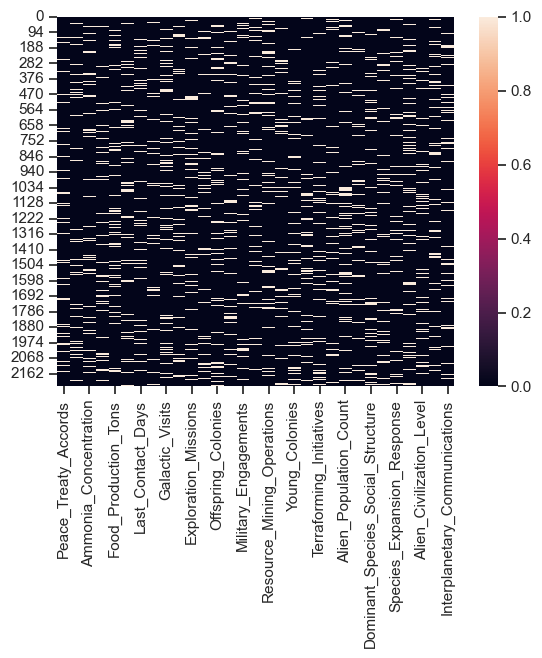

In [17]:
# Missing values plot
sns.heatmap(dat.isnull())

# check MCAR test to evaluate missing pattern in dataset
mcarTest = MCARTest(method="little")
print(mcarTest.little_mcar_test(dat3))
#NOTE: since p-value < 0.05, we can say that missing pattern of given dataset is missing completely at rondom.
# Now, we can use any ML algorithim to impute the missing values.

In [18]:
# impute missing values based on KNN algorithm
imputer = KNNImputer(n_neighbors= 5)
dat_comp = imputer.fit_transform(dat3)
#print(dat_comp)

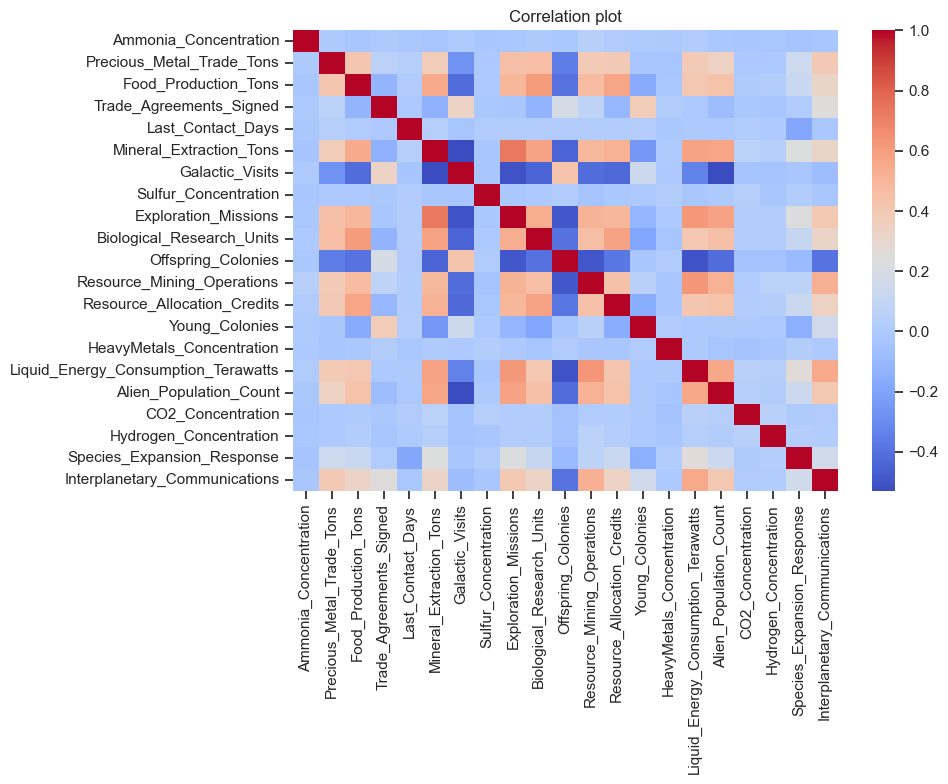

In [19]:
# correlation plot
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(dat_comp, columns=dat3.columns).corr(), cmap='coolwarm')
plt.title('Correlation plot')
plt.tight_layout()

### 3) Machine learning algorithms

#### 3.1) Principal component analysis

In [20]:
# standardizing the data
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(dat_comp), columns= num_dat.columns)
scaled_data.head()

Ammonia_Concentration  Precious_Metal_Trade_Tons  Food_Production_Tons  \
0              -0.469608                  -0.065325              2.131531   
1               0.562093                   1.271873              0.615392   
2              -0.469608                   2.314101              0.719954   
3              -0.469608                   1.252208             -0.466817   
4              -1.501309                  -0.281637              0.876796   

   Trade_Agreements_Signed  Last_Contact_Days  Mineral_Extraction_Tons  \
0                -0.716686          -1.265927                 1.022205   
1                -0.716686          -0.100305                 1.332544   
2                -0.167464           0.460919                 0.895166   
3                 0.381758           0.007622                -0.511340   
4                 2.578647          -0.870191                 0.051262   

   Galactic_Visits  Sulfur_Concentration  Exploration_Missions  \
0        -0.998548             -1.463651              0.485900   
1        -1.421853              0.743056              1.181284   
2        -0.151936              0.743056              2.224361   
3         0.694675              0.007487              0.138208   
4        -0.998548              0.007487              1.181284   

   Biological_Research_Units  ...  Resource_Mining_Operations  \
0                   2.593320  ...                    0.736789   
1                   0.119616  ...                    1.690560   
2                   1.618830  ...                    2.326408   
3                  -0.611251  ...                   -0.534907   
4                   0.756782  ...                    0.736789   

   Resource_Allocation_Credits  Young_Colonies  HeavyMetals_Concentration  \
0                     1.023102       -0.955992                   1.003727   
1                    -0.456886        0.959412                   0.006057   
2                     2.026484        0.959412                  -0.991612   
3                    -0.582309        0.959412                   0.006057   
4                    -0.532139        0.959412                   0.006057   

   Liquid_Energy_Consumption_Terawatts  Alien_Population_Count  \
0                             1.048721                1.074609   
1                             0.848241                0.449433   
2                             1.288690                0.701067   
3                             0.037206               -0.315342   
4                            -0.035696                0.255388   

   CO2_Concentration  Hydrogen_Concentration  Species_Expansion_Response  \
0           1.654149                1.178736                   -0.428236   
1           1.654149                0.205551                   -0.428236   
2          -0.134017               -1.037913                   -0.428236   
3          -0.277070               -0.452612                    2.505248   
4           0.938883                0.940504                   -0.428236   

   Interplanetary_Communications  
0                       0.756598  
1                       0.377232  
2                       1.515330  
3                       1.135964  
4                      -0.002134  

[5 rows x 21 columns]

In [21]:
# PCA visualization
pca_dat = scaled_data
pca_dat.index = dat1['Alien_Civilization_Level'].values
pca_dat.head()

Ammonia_Concentration  Precious_Metal_Trade_Tons  \
Master                  -0.469608                  -0.065325   
Master                   0.562093                   1.271873   
Graduation              -0.469608                   2.314101   
Master                  -0.469608                   1.252208   
Graduation              -1.501309                  -0.281637   

            Food_Production_Tons  Trade_Agreements_Signed  Last_Contact_Days  \
Master                  2.131531                -0.716686          -1.265927   
Master                  0.615392                -0.716686          -0.100305   
Graduation              0.719954                -0.167464           0.460919   
Master                 -0.466817                 0.381758           0.007622   
Graduation              0.876796                 2.578647          -0.870191   

            Mineral_Extraction_Tons  Galactic_Visits  Sulfur_Concentration  \
Master                     1.022205        -0.998548             -1.463651   
Master                     1.332544        -1.421853              0.743056   
Graduation                 0.895166        -0.151936              0.743056   
Master                    -0.511340         0.694675              0.007487   
Graduation                 0.051262        -0.998548              0.007487   

            Exploration_Missions  Biological_Research_Units  ...  \
Master                  0.485900                   2.593320  ...   
Master                  1.181284                   0.119616  ...   
Graduation              2.224361                   1.618830  ...   
Master                  0.138208                  -0.611251  ...   
Graduation              1.181284                   0.756782  ...   

            Resource_Mining_Operations  Resource_Allocation_Credits  \
Master                        0.736789                     1.023102   
Master                        1.690560                    -0.456886   
Graduation                    2.326408                     2.026484   
Master                       -0.534907                    -0.582309   
Graduation                    0.736789                    -0.532139   

            Young_Colonies  HeavyMetals_Concentration  \
Master           -0.955992                   1.003727   
Master            0.959412                   0.006057   
Graduation        0.959412                  -0.991612   
Master            0.959412                   0.006057   
Graduation        0.959412                   0.006057   

            Liquid_Energy_Consumption_Terawatts  Alien_Population_Count  \
Master                                 1.048721                1.074609   
Master                                 0.848241                0.449433   
Graduation                             1.288690                0.701067   
Master                                 0.037206               -0.315342   
Graduation                            -0.035696                0.255388   

            CO2_Concentration  Hydrogen_Concentration  \
Master               1.654149                1.178736   
Master               1.654149                0.205551   
Graduation          -0.134017               -1.037913   
Master              -0.277070               -0.452612   
Graduation           0.938883                0.940504   

            Species_Expansion_Response  Interplanetary_Communications  
Master                       -0.428236                       0.756598  
Master                       -0.428236                       0.377232  
Graduation                   -0.428236                       1.515330  
Master                        2.505248                       1.135964  
Graduation                   -0.428236                      -0.002134  

[5 rows x 21 columns]

Text(0, 0.5, 'PCA 2')

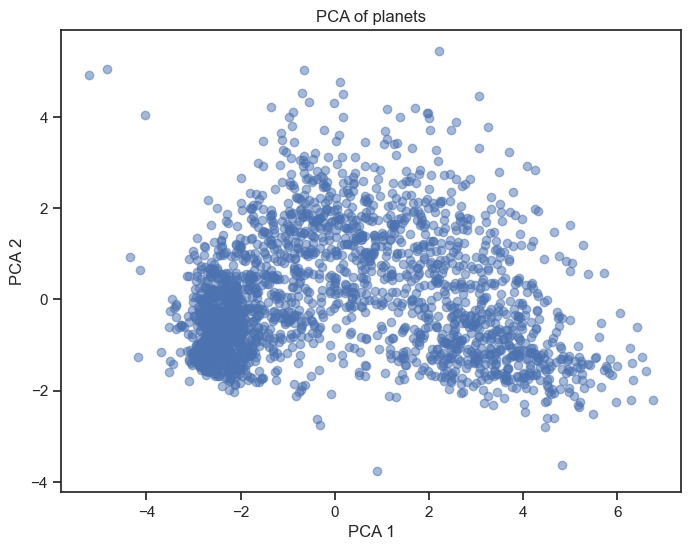

In [22]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_dat)
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title("PCA of planets")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

C:\Users\faran\AppData\Local\Temp\ipykernel_9732\3644084543.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loadings.PC1[i]*2,
C:\Users\faran\AppData\Local\Temp\ipykernel_9732\3644084543.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  loadings.PC2[i]*2,
C:\Users\faran\AppData\Local\Temp\ipykernel_9732\3644084543.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(loadings.PC1[i]*2.2,
C:\Users\faran\AppData\Local\

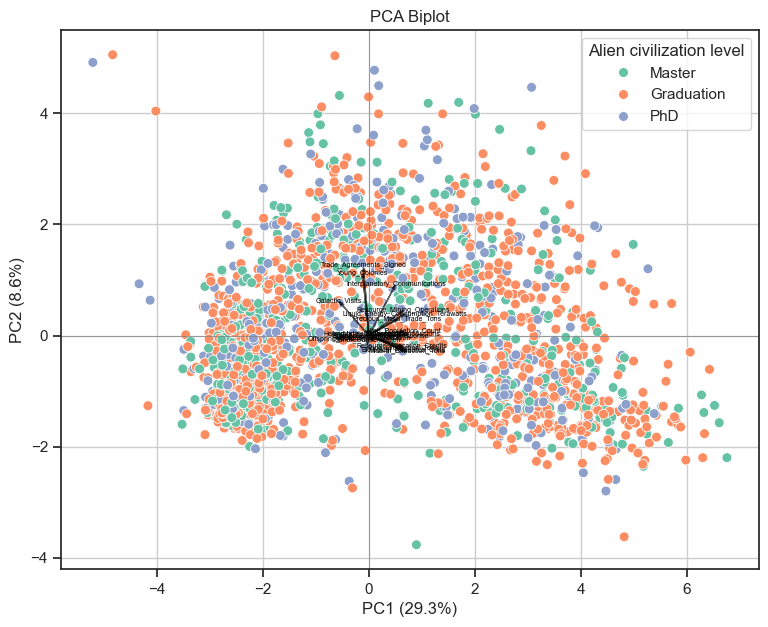

In [23]:
# dataFrame of scores
pca_scores = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=pca_dat.index)

# dataFrame of loadings
loadings = pd.DataFrame(pca.components_.T,
                        columns=['PC1', 'PC2'],
                        index=pca_dat.columns)

# PCA biplot
plt.figure(figsize=(9, 7))
sns.scatterplot(x='PC1', y='PC2', hue=pca_scores.index, data=pca_scores, palette='Set2', s=50)

# Plot the loadings
for i in range(loadings.shape[0]):
    plt.arrow(0, 0, 
              loadings.PC1[i]*2, 
              loadings.PC2[i]*2, 
              color='black', alpha=0.6, head_width=0.05)
    plt.text(loadings.PC1[i]*2.2, 
             loadings.PC2[i]*2.2, 
             loadings.index[i], 
             color='black', ha='center', va='center', fontsize=5)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title('PCA Biplot')
plt.grid(True)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.legend(title='Alien civilization level')

#### 3.2) Kmeans clustering

Text(0.5, 1.0, 'Silhouette analysis')

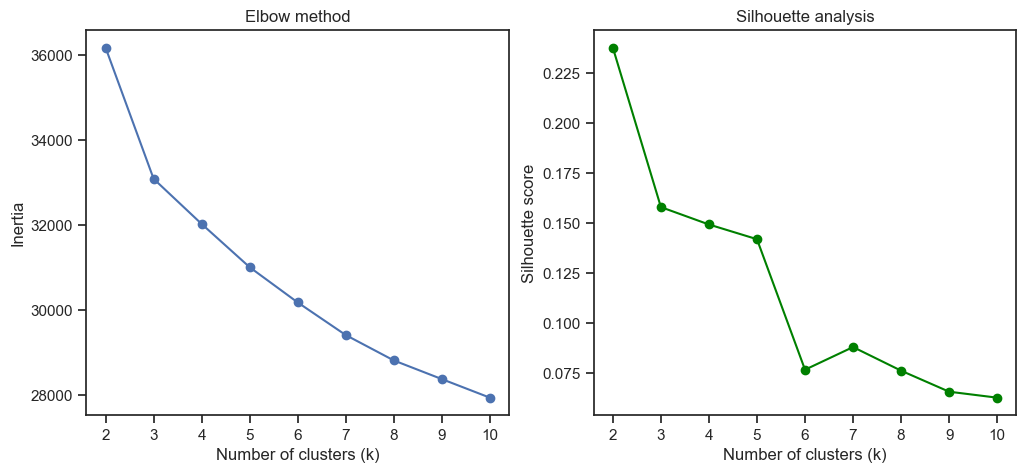

In [24]:
kmeans_dat = pca_dat 

# range of cluster values to test
k_range = range(2, 11)
inertias = []
silhouettes = []

# looping over different k values
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(kmeans_dat)
    inertias.append(model.inertia_)
    labels = model.labels_
    silhouettes.append(silhouette_score(kmeans_dat, labels))

# plot using elbow method
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow method')

# plot of silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='o', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis')



C:\Users\faran\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


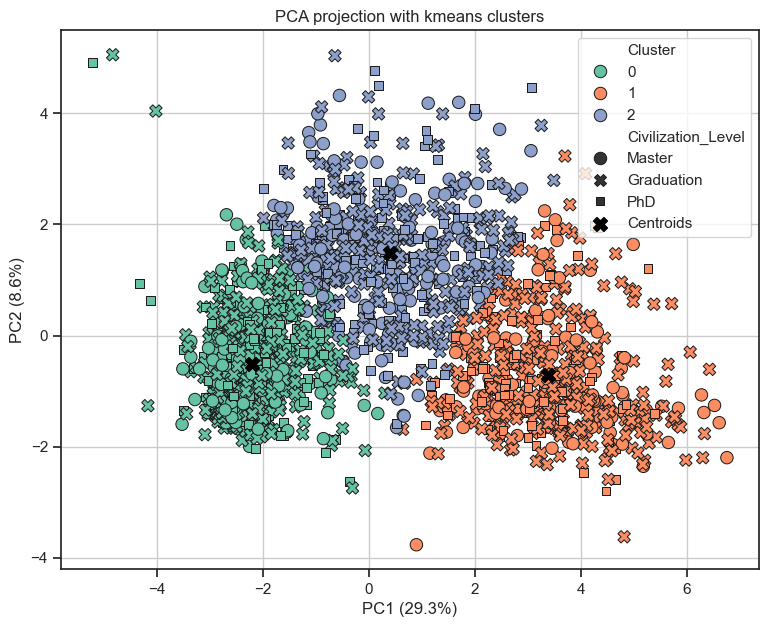

In [25]:
# Kmeans with selected best k
best_k = 3 
final_kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = final_kmeans.fit_predict(kmeans_dat)
centroids = final_kmeans.cluster_centers_

# PCA plotting with kmeans clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(kmeans_dat)
centroids_pca = pca.transform(centroids)

pca_df0 = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df0['Cluster'] = kmeans_labels
pca_df0['Civilization_Level'] = kmeans_dat.index

plt.figure(figsize=(9, 7))
sns.scatterplot(data=pca_df0, x='PC1', y='PC2', hue='Cluster', style='Civilization_Level', palette='Set2', s=80, edgecolor='k')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=100, c='black', marker='X', label='Centroids')
plt.title('PCA projection with kmeans clusters')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.grid(True)

#### 3.3) Agglomerative clustering

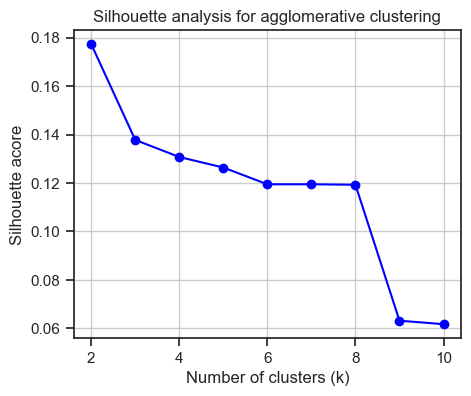

In [26]:
# range of cluster values to test
k_range = range(2, 11)
silhouettes = []

# looping over different k values
for k in k_range:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward')  # Ward as distance measure to minimize the variance of the clusters
    labels = model.fit_predict(kmeans_dat)
    silhouettes.append(silhouette_score(kmeans_dat, labels))

# silhouette scores plot
plt.figure(figsize=(5, 4))
plt.plot(k_range, silhouettes, marker='o', color='blue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette acore')
plt.title('Silhouette analysis for agglomerative clustering')
plt.grid(True)

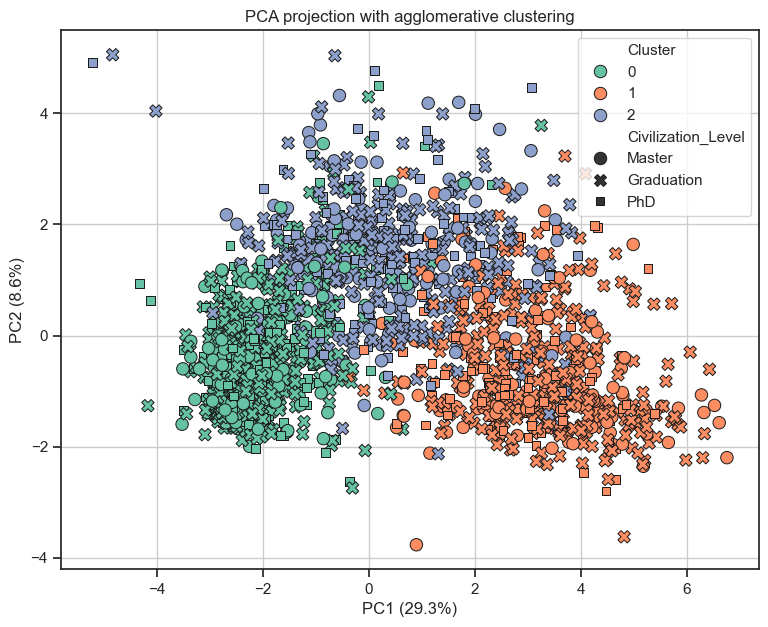

In [27]:
# agglomerative clustering with selected best k
best_k = 3  
final_agglomerative = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = final_agglomerative.fit_predict(kmeans_dat)

# PCA plot with agglomerative clusters
pca_df1 = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df1['Cluster'] = agg_labels
pca_df1['Civilization_Level'] = kmeans_dat.index

plt.figure(figsize=(9, 7))
sns.scatterplot(data=pca_df1, x='PC1', y='PC2', hue='Cluster', style='Civilization_Level', palette='Set2', s=80, edgecolor='k')
plt.title('PCA projection with agglomerative clustering')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.grid(True)

#### 3.4) Gaussian Mixture Model (GMM)

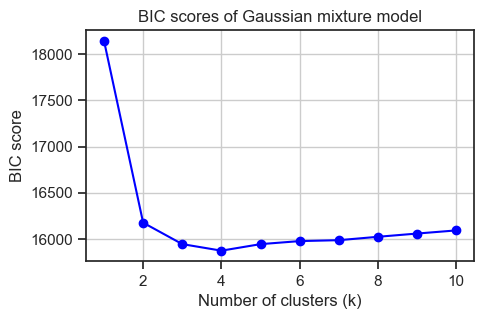

In [28]:
# fit a GMM to the PCA result
# test different k values for GMM by using BIC
bic_scores = []
k_range = range(1, 11) 
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(pca_result)
    bic_scores.append(gmm.bic(pca_result))

# BIC scores plot; to select the optimal number of clusters
plt.figure(figsize=(5, 3))
plt.plot(k_range, bic_scores, marker='o', color='blue')
plt.title('BIC scores of Gaussian mixture model')
plt.xlabel('Number of clusters (k)')
plt.ylabel('BIC score')
plt.grid(True)


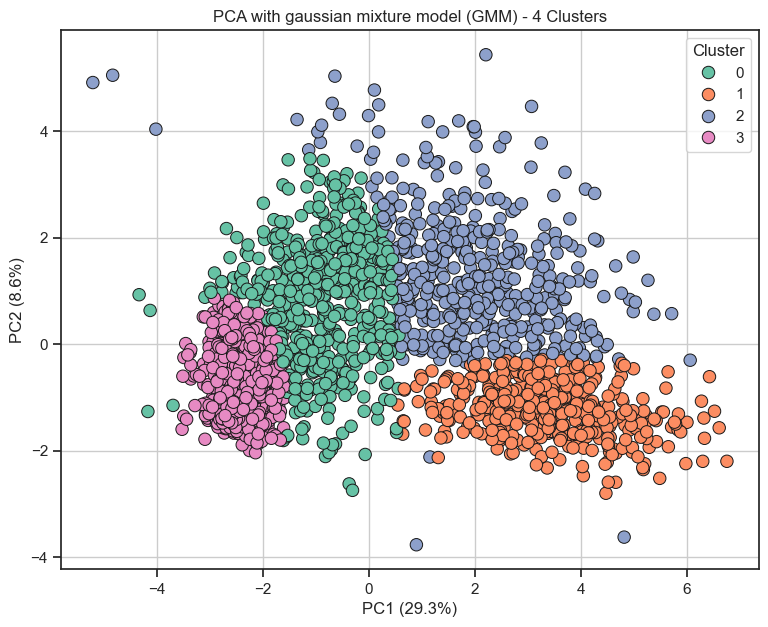

In [29]:
# selecting best k based on BIC (lowest BIC)
best_k = k_range[np.argmin(bic_scores)]

# GMM with the best k
final_gmm = GaussianMixture(n_components=best_k, random_state=42)
gmm_labels = final_gmm.fit_predict(pca_result)

# PCA plot with GMM cluster labels
pca_df2 = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df2['Cluster'] = gmm_labels

plt.figure(figsize=(9, 7))
sns.scatterplot(data=pca_df2, x='PC1', y='PC2', hue='Cluster', palette='Set2', s=80, edgecolor='k')
plt.title(f'PCA with gaussian mixture model (GMM) - {best_k} Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.legend(title='Cluster', loc='best')
plt.grid(True)

### 4) Evaluating model's performance

In [30]:
# 1) Silhouette score
kmeans_silhouette = silhouette_score(kmeans_dat, kmeans_labels)
agg_silhouette = silhouette_score(kmeans_dat, agg_labels)
gmm_silhouette = silhouette_score(kmeans_dat, gmm_labels)

# 2) Calinski-Harabasz index
kmeans_ch = calinski_harabasz_score(kmeans_dat, kmeans_labels)
agg_ch = calinski_harabasz_score(kmeans_dat, agg_labels)
gmm_ch = calinski_harabasz_score(kmeans_dat, gmm_labels)

# 3) Davies-Bouldin index
kmeans_db = davies_bouldin_score(kmeans_dat, kmeans_labels)
agg_db = davies_bouldin_score(kmeans_dat, agg_labels)
gmm_db = davies_bouldin_score(kmeans_dat, gmm_labels)


results = {
    'Kmeans': {
        'Silhouette score': kmeans_silhouette,
        'Calinski-Harabasz index': kmeans_ch,
        'Davies-Bouldin index': kmeans_db
    },
    'Agglomerative clustering': {
        'Silhouette score': agg_silhouette,
        'Calinski-Harabasz index': agg_ch,
        'Davies-Bouldin index': agg_db
    },
    'GMM': {
        'Silhouette score': gmm_silhouette,
        'Calinski-Harabasz index': gmm_ch,
        'Davies-Bouldin index': gmm_db
    }
}
comparison_df = pd.DataFrame(results)
print(comparison_df)


                             Kmeans  Agglomerative clustering         GMM
Silhouette score           0.157994                  0.137763    0.085676
Calinski-Harabasz index  471.540071                404.651342  320.423960
Davies-Bouldin index       2.160999                  2.368362    2.928240


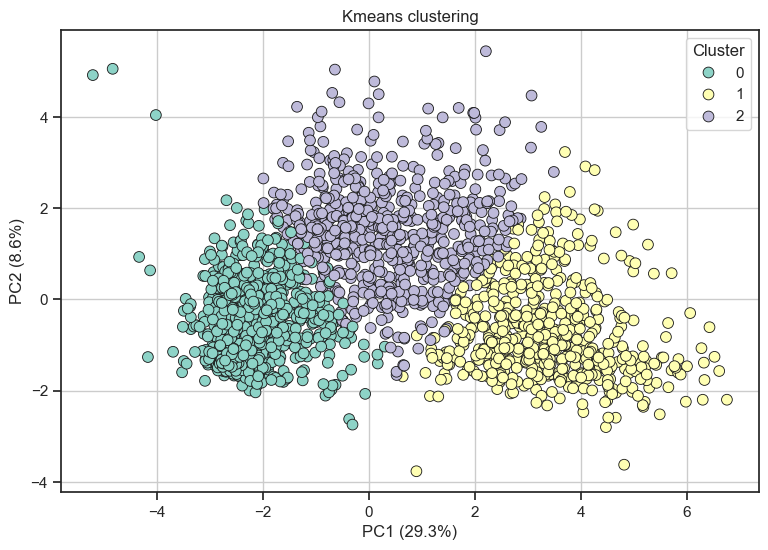

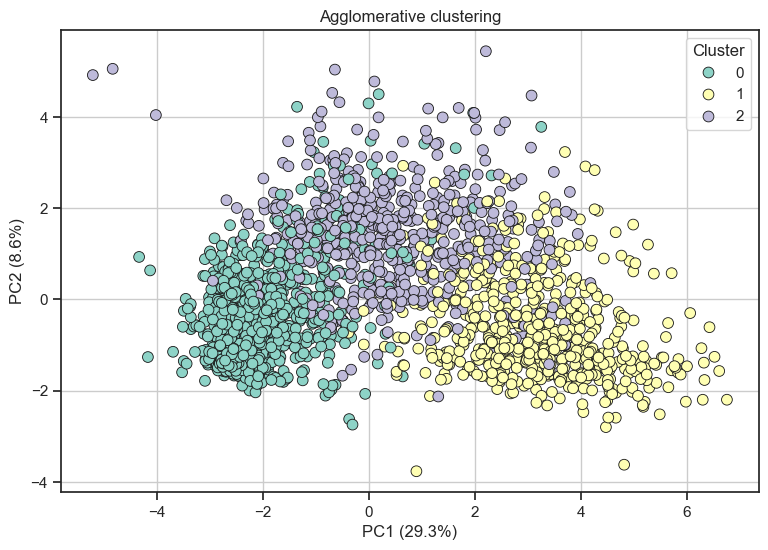

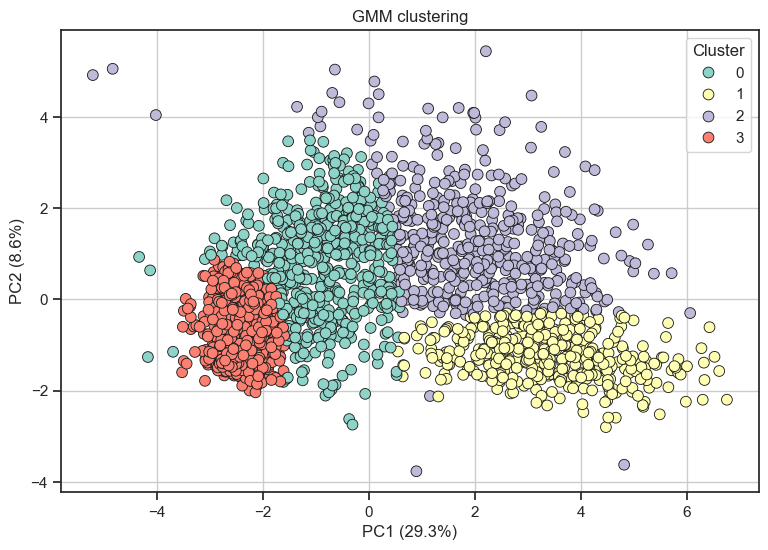

In [31]:
# Visualizing the clustering results
def plot_clusters(dat, labels, title):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dat)
    plt.figure(figsize=(9, 6))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set3', s=60, edgecolor='k')
    plt.title(title)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.legend(title='Cluster', loc='best')
    plt.grid(True)

plot_clusters(kmeans_dat, kmeans_labels, 'Kmeans clustering')
plot_clusters(kmeans_dat, agg_labels, 'Agglomerative clustering')
plot_clusters(kmeans_dat, gmm_labels, 'GMM clustering')